### Assignment 1 - Invasive Species

### Setup

In [1]:
%matplotlib inline

In [20]:
path = 'data/invasivespecies/'

# NEVER ENABLE THIS WHEN CREATING VALIDATION SET (STEP 1)
# path = 'data/invasivespecies/sample/'

In [6]:
from __future__ import division, print_function

import os, json
from glob import glob
import pandas as pd
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt

import utils; reload(utils)
from utils import plots

# Dataset formatting
from os import walk
import shutil

### Step 1: Create Validation set and sample

In [1]:
# Just testing out command line
%cd data
%cd ../

/home/ubuntu/courses/deeplearning1/nbs/data
/home/ubuntu/courses/deeplearning1/nbs


In [3]:
!kg config -g -c 'invasive-species-monitoring'

In [18]:
models_folder = path+'models/'
if not os.path.exists(models_folder):
    os.makedirs(models_folder)

In [16]:
# Unzip training folder
originals_folder = path+'train_original/'
# !7z --help
if not os.path.exists(originals_folder):
    !7z e {path}train.7z -o{originals_folder}

In [54]:
# Unzip training folder
test_folder = path+'test/test/'
if not os.path.exists(test_folder):
    !7z e {path}test.7z -o{test_folder}
    
# Create sample test folder
_, _, filenames = next(walk(test_folder))
shuf = np.random.permutation(filenames)

sample_test_folder = path+'sample/test/test/'
if not os.path.exists(sample_test_folder):
    os.makedirs(sample_test_folder)
for i in range(20):
    shutil.copyfile(test_folder+shuf[i], sample_test_folder+shuf[i])
    

In [40]:
# Get training labels
training_labels_df = pd.read_csv(path + 'train_labels.csv')
size = training_labels_df.size
num_positives = training_labels_df['invasive'].sum()
print('Size:', size)
print('Positives: {} Percent: {}'.format(num_positives, num_positives/size))


Size: 4590
Positives: 1448 Percent: 0.315468409586


In [41]:
# Get training files
import re

_, _, filenames = next(walk(originals_folder))


p = re.compile('^([0-9]+).jpg')
def find_file_id(filename):
    m = p.match(filename)
    if m is not None:
        return int(m.group(1))
    else:
        print('Could not regex filename: ', filename)
        return -1
file_ids = map(find_file_id, filenames)

# Merge data into one dataframe:
file_df = pd.DataFrame([file_ids, filenames], index=['name', 'file']).transpose()

In [50]:
# Label files and move to labeled folder


labeled_folder = path+'labeled/'
if not os.path.exists(labeled_folder):
    os.makedirs(labeled_folder)
    
labeled_df = pd.merge(training_labels_df, file_df, on='name')
for row in labeled_df.itertuples():
    label = 'invasive.' if row[2] == 1 else 'noninvasive.'
    file_name = row[3]
    new_file = labeled_folder+label+file_name;
    shutil.copyfile(originals_folder+file_name, new_file)
    

In [96]:
# Separate images into training and validation sets
train_folder = path+'train/'
shutil.copytree(labeled_folder, train_folder)
_, _, filenames = next(walk(train_folder))
shuf = np.random.permutation(filenames)
size = len(filenames)
print(size)

valid_folder = path+'valid/'
if not os.path.exists(valid_folder):
    os.makedirs(valid_folder)
    
sample_train_folder = path+'sample/train/'
if not os.path.exists(sample_train_folder):
    os.makedirs(sample_train_folder)
for i in range(200):
    copyfile(train_folder+shuf[i], sample_train_folder+shuf[i])
    
sample_valid_folder = path+'sample/valid/'
if not os.path.exists(sample_valid_folder):
    os.makedirs(sample_valid_folder)
for i in range(200):
    copyfile(train_folder+shuf[i], sample_valid_folder+shuf[i])
    
validation_size = int(round(size * .3))
for i in range(validation_size):
    os.rename(train_folder+shuf[i], valid_folder+shuf[i])



2295


In [97]:
def classify_folders(folder):
    if not os.path.exists(folder+'noninvasive'):
        os.makedirs(folder+'noninvasive')
        os.makedirs(folder+'invasive')
    inv = glob(folder+'invasive.*.jpg')
    noninv = glob(folder+'noninvasive.*.jpg')
    move_files_to(inv, folder, folder+'invasive/')
    move_files_to(noninv, folder, folder+'noninvasive/')
    
def move_files_to(files, old_folder, new_folder):
    for fname in files:
        newf = fname.replace(old_folder, new_folder)
        os.rename(fname, newf)
        
classify_folders(train_folder)
classify_folders(valid_folder)
classify_folders(sample_train_folder)
classify_folders(sample_valid_folder)

# VGG

In [7]:
# batch_size=64
batch_size=8

In [31]:
import vgg16; reload(vgg16)
from vgg16 import Vgg16

In [32]:
vgg = Vgg16()

#### Visualize data

In [23]:
batches = vgg.get_batches(path+'train', batch_size=4)
imgs,labels = next(batches)

Found 1606 images belonging to 2 classes.


In [24]:
print(imgs.shape)
print(labels.shape)

(4, 3, 224, 224)
(4, 2)


In [25]:
imgs[0, :, 0, 0]

array([ 14.,  47.,  18.])

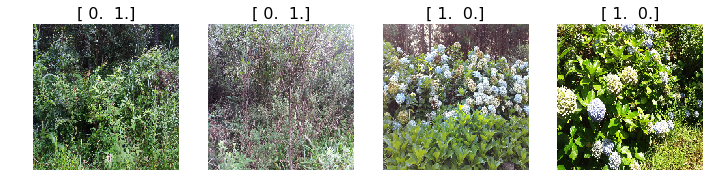

In [26]:
plots(imgs, titles=labels)

In [27]:
vgg.predict(imgs, True)

(array([ 0.0955,  0.0866,  0.3067,  0.6538], dtype=float32),
 array([101, 295, 825, 825]),
 [u'tusker', u'American_black_bear', u'stone_wall', u'stone_wall'])

In [28]:
vgg.classes[:4]

[u'tench', u'goldfish', u'great_white_shark', u'tiger_shark']

### Finetune Model

In [34]:
weights_file = 'trained_weights.h5'
weights_fullpath = models_folder + weights_file

In [35]:
def train_vgg():
    batch_size=64
    batches = vgg.get_batches(path+'train', batch_size=batch_size)
    val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
    vgg.finetune(batches)
    vgg.fit(batches, val_batches, nb_epoch=1)

    vgg.model.save_weights(weights_fullpath)
    
train_vgg()

Found 1606 images belonging to 2 classes.
Found 1167 images belonging to 2 classes.
Epoch 1/1
1606/1606 [==============================] - 115s - loss: 0.6377 - acc: 0.7802 - val_loss: 0.2938 - val_acc: 0.8698


#### Load from Cache:

In [30]:
if os.path.exists(weights_fullpath):
    vgg.model.load_weights(weights_fullpath)
    print('Loaded model from cache')
    

Loaded model from cache


### Predict results in test set

In [73]:
testFolder = path+'test/'

# another test directory embeded in test folder
embeddedFolder = testFolder+'test/'
_, _, files = os.walk(embeddedFolder).next()
num_test_images = len(files)
test_batch_size = 100

print(num_test_images)
# num_test_images = 8
# test_batch_size = 1

batches = vgg.get_batches(testFolder, batch_size=test_batch_size, shuffle=False, class_mode=None)


1531
Found 1531 images belonging to 1 classes.


Let's look at our predictions...

Need to convert file names to label ids

In [76]:
import re
filenames = batches.filenames

p = re.compile('.*/([0-9]+).jpg')
def find_file_id(filename):
    m = p.match(filename)
    if m is not None:
        return int(m.group(1))
    else:
        print('Could not regex filename: ', filename)
        return -1
file_ids = map(find_file_id, filenames)

Option A: Predict values using vgg test function (Not recommended. No progress)

Option B: Predict values with batches and progress

In [74]:
import math
from tqdm import tqdm

predict_file = models_folder + 'predict.bc'

def predict_test():
    batches = vgg.get_batches(testFolder, batch_size=test_batch_size, shuffle=False, class_mode=None)

    p_results = np.zeros(num_test_images)
    current_index = 0
    # Iterative loop
    for batch in tqdm(batches, total=math.ceil(num_test_images/test_batch_size)):
        if batch is None:
            break
        p = vgg.model.predict_on_batch(batch)
        p_true = p[:, 1]
        p_size = p.shape[0]
        print('Predictions: {}\n Size: {}'.format(p_true, p_size))
        new_index = current_index + p_size
        print('Current index: {} New index: {} PResults: {}'.format(current_index, new_index, p_results))
        p_results[current_index:new_index] = p_true
        current_index = new_index
        if current_index >= num_test_images:
            break
    print(p_results)
    utils.save_array(predict_file, p_results)
    return p_results

if os.path.exists(predict_file):
    p_results = utils.load_array(predict_file)
    print('Loaded predictions from cache')
else:
    p_results = predict_test()



  0%|          | 0/16.0 [00:00<?, ?it/s]

Found 1531 images belonging to 1 classes.




  6%|▋         | 1/16.0 [00:06<01:32,  6.15s/it]

Predictions: [  2.4501e-03   8.4538e-01   7.9443e-01   4.3981e-03   4.4838e-01   1.6434e-08   2.0930e-06
   2.6039e-01   8.7993e-01   6.6605e-01   8.1523e-01   4.9564e-02   8.7361e-01   9.7938e-02
   5.4548e-01   1.9215e-04   7.5137e-07   8.5644e-01   3.8991e-04   9.1794e-01   8.5171e-02
   7.0636e-01   2.8672e-05   1.5795e-01   9.9160e-01   1.0066e-03   3.1291e-05   1.2742e-05
   3.9524e-01   5.9823e-01   9.0627e-06   2.5790e-07   2.9407e-03   2.5710e-01   9.3519e-01
   8.2596e-01   7.1266e-01   9.6811e-01   6.9204e-07   7.6849e-03   9.9119e-01   2.4167e-06
   6.3813e-04   2.4308e-02   8.5132e-01   3.7376e-06   9.8314e-01   8.9054e-01   5.0172e-01
   6.9564e-01   9.9120e-01   6.6617e-01   1.9704e-06   1.6710e-05   6.9880e-01   4.5501e-06
   3.2142e-01   9.9180e-01   4.5664e-01   2.9752e-01   9.9381e-01   5.9899e-01   2.4345e-03
   2.1728e-06   3.9856e-01   7.8267e-02   5.5386e-04   4.1860e-01   1.9881e-04   9.2460e-02
   9.1671e-01   7.6462e-01   7.7941e-01   9.0556e-05   9.4418e-01  




 12%|█▎        | 2/16.0 [00:12<01:25,  6.12s/it]

Predictions: [  5.3477e-05   5.6163e-01   3.9369e-01   2.4204e-01   9.2856e-01   9.9879e-01   3.9211e-01
   6.4893e-04   2.6317e-06   9.7651e-01   1.8686e-02   1.6658e-01   9.2296e-01   9.3582e-01
   9.7010e-01   9.8722e-01   7.2531e-04   3.6887e-01   1.4853e-01   4.5569e-01   5.5971e-01
   1.4014e-02   7.0741e-01   2.9045e-01   9.5040e-03   9.4242e-01   9.1748e-01   5.5387e-05
   5.7624e-04   2.6828e-07   2.7371e-08   7.4297e-01   6.8464e-08   8.5905e-01   9.8344e-01
   6.9925e-01   5.6843e-04   9.8165e-01   2.2754e-01   8.3690e-01   5.2245e-02   8.9520e-03
   1.1754e-07   8.5952e-01   4.9033e-01   3.2520e-01   4.2355e-05   9.3303e-01   2.9338e-08
   8.4343e-01   5.4910e-01   2.0394e-01   3.5585e-01   3.4292e-01   3.3222e-07   7.9051e-01
   6.7515e-01   6.1435e-01   9.5898e-01   9.1279e-01   9.4098e-01   8.3920e-01   9.9998e-01
   2.4332e-01   4.7853e-01   7.1737e-01   8.7247e-01   2.5248e-08   4.2704e-01   9.3744e-01
   8.8435e-01   5.7677e-01   5.4880e-01   9.4119e-01   9.7254e-01  



 19%|█▉        | 3/16.0 [00:18<01:19,  6.10s/it]

Predictions: [  9.5434e-01   9.4301e-01   5.5815e-06   3.6590e-01   9.7881e-01   5.5990e-07   2.0273e-01
   7.9152e-06   4.1690e-02   3.0651e-04   9.5797e-01   9.7451e-01   7.9470e-01   7.7551e-01
   3.2812e-01   4.8205e-01   1.1906e-05   2.6973e-04   1.0743e-05   1.4662e-01   6.3459e-01
   2.0889e-06   3.6322e-04   9.8411e-01   3.1727e-06   4.5928e-01   5.4455e-01   9.2857e-01
   5.2204e-06   8.4080e-01   4.2280e-04   9.4869e-01   9.7752e-01   2.3124e-01   9.9427e-05
   7.9566e-06   9.9586e-01   3.9285e-01   2.0469e-01   6.7286e-01   4.9179e-02   8.2383e-01
   9.8419e-01   3.1373e-03   9.0243e-01   6.6777e-02   8.1772e-01   1.8835e-04   8.9038e-01
   6.6310e-04   8.4939e-03   2.3660e-02   1.1954e-04   3.9956e-01   6.9836e-01   4.4965e-01
   9.2399e-01   9.9783e-01   1.1271e-06   4.7881e-04   1.4531e-01   9.9948e-01   6.4590e-07
   4.2080e-04   4.6734e-01   3.0932e-02   1.5887e-06   1.3738e-03   9.8667e-01   1.0979e-05
   1.0920e-01   7.1008e-02   9.8147e-01   9.9472e-01   1.9451e-05  



 25%|██▌       | 4/16.0 [00:24<01:13,  6.09s/it]

Predictions: [  3.1459e-04   6.0734e-01   8.4960e-01   9.7863e-01   6.5485e-03   2.0713e-01   3.8106e-01
   7.6929e-01   3.8683e-01   1.0371e-01   6.9166e-05   4.9427e-01   3.8570e-01   4.6189e-03
   9.8642e-01   1.7516e-01   1.7658e-05   9.5435e-01   2.8309e-03   4.6015e-01   7.2016e-01
   6.6288e-01   7.7915e-01   5.9645e-03   2.6146e-04   4.9101e-02   9.8417e-01   9.5438e-01
   4.9112e-02   3.9369e-05   9.9307e-01   8.4484e-01   2.6754e-05   9.7752e-04   1.4374e-02
   8.3808e-02   1.8489e-01   6.0020e-01   4.7424e-08   9.1256e-01   5.0672e-02   5.6496e-01
   2.7227e-01   8.4583e-01   2.6880e-01   2.9230e-01   1.0036e-01   9.5537e-04   6.7356e-01
   1.2175e-05   9.5983e-06   5.1817e-02   1.7197e-02   2.0433e-07   9.1264e-01   1.0224e-02
   7.7528e-01   4.9624e-02   1.2319e-03   1.7171e-03   5.4160e-06   9.5937e-01   3.0135e-01
   7.4029e-07   9.7134e-01   9.9572e-01   8.0206e-06   8.5790e-01   9.3269e-01   9.7090e-01
   9.9616e-01   1.8497e-03   6.7338e-01   9.6666e-01   5.7548e-02  



 31%|███▏      | 5/16.0 [00:30<01:06,  6.07s/it]

Predictions: [  3.1744e-07   6.9797e-01   9.9031e-01   1.7110e-05   5.1062e-06   8.3081e-01   9.8673e-01
   9.6697e-01   4.7548e-01   6.9466e-01   2.5895e-05   5.9991e-04   9.6101e-01   5.2562e-03
   3.8731e-04   5.4385e-01   9.2137e-02   2.0585e-04   4.2082e-01   1.1983e-01   8.7370e-01
   9.6302e-01   9.8669e-01   9.8333e-01   9.0293e-01   2.4328e-02   1.2012e-07   9.3997e-01
   9.3609e-01   8.8093e-01   5.9364e-01   1.9215e-03   7.6320e-01   9.2459e-01   7.1622e-01
   2.0232e-02   9.2578e-01   2.9137e-02   9.9755e-01   3.1608e-01   9.9216e-01   5.4845e-05
   1.8141e-08   4.8898e-01   7.2784e-05   9.6511e-01   2.6790e-01   9.1801e-01   3.1759e-07
   9.4535e-02   3.3512e-02   1.8351e-04   1.7629e-02   9.9131e-01   4.4096e-01   9.0032e-01
   1.5616e-01   3.1337e-06   6.3445e-01   9.4938e-01   3.6489e-05   2.0036e-01   1.1697e-06
   1.4219e-05   9.4762e-01   7.3466e-01   3.9008e-02   2.6336e-05   9.1780e-01   9.7829e-01
   9.0979e-01   2.0807e-07   3.5551e-01   9.9043e-01   6.6412e-01  



 38%|███▊      | 6/16.0 [00:36<01:00,  6.05s/it]

Predictions: [  1.7450e-01   6.9749e-01   3.9582e-04   6.6097e-01   6.3894e-01   2.5382e-03   7.1596e-01
   5.6277e-06   3.4667e-02   4.6552e-01   7.9829e-01   3.6317e-02   6.6505e-02   7.5734e-01
   8.7927e-01   9.0948e-02   7.2109e-01   7.6107e-03   9.5235e-01   4.8310e-06   9.2934e-03
   8.1290e-04   7.9821e-01   7.5041e-01   8.2729e-03   6.9293e-01   3.3153e-01   8.2506e-01
   6.2644e-03   1.3478e-07   3.6072e-01   9.3538e-01   3.1183e-01   5.7409e-05   2.5875e-02
   9.6664e-01   5.0851e-02   4.8335e-02   2.0886e-01   9.0986e-03   1.8249e-04   9.2146e-01
   5.8241e-01   2.4084e-02   5.0990e-08   5.0619e-08   6.0621e-01   1.9887e-01   7.1819e-01
   9.8455e-01   7.0152e-01   4.6390e-04   9.8468e-01   7.2336e-01   1.2084e-04   5.4222e-01
   9.3813e-01   4.9031e-07   4.1233e-06   1.7289e-01   9.3865e-07   9.4664e-01   2.7891e-01
   5.7010e-05   9.6237e-01   9.4713e-04   2.1731e-03   3.5552e-01   4.8839e-02   1.7415e-04
   9.8632e-01   8.8634e-01   4.4444e-01   2.3381e-03   9.5635e-01  



 44%|████▍     | 7/16.0 [00:42<00:54,  6.06s/it]

Predictions: [  1.7477e-03   3.1148e-02   7.0812e-04   2.0608e-01   9.9381e-01   8.6100e-01   9.4209e-01
   9.4982e-01   9.4370e-01   7.1009e-09   5.9295e-05   9.9071e-01   5.5626e-01   8.8550e-01
   7.1164e-01   3.8151e-01   7.2443e-01   2.2197e-01   5.4014e-05   6.1251e-01   1.3470e-01
   8.5739e-01   2.0493e-03   9.4054e-01   2.5545e-05   8.8481e-01   1.8019e-06   9.4903e-07
   1.7581e-01   8.3777e-01   1.5512e-01   2.1062e-01   8.0248e-01   1.0231e-05   1.8674e-04
   2.4957e-01   1.3661e-03   7.1119e-05   7.2024e-01   2.5059e-01   9.1720e-01   9.5441e-01
   6.0170e-03   9.0263e-09   1.0936e-04   2.4697e-02   8.1768e-01   1.9725e-02   9.7373e-01
   8.6289e-01   8.4540e-01   9.2038e-07   8.1033e-01   5.2415e-01   6.4514e-01   7.9120e-01
   5.3032e-01   3.8221e-01   6.3891e-02   7.5226e-01   3.2897e-01   1.4118e-01   3.5880e-01
   2.8161e-01   8.8684e-04   1.6950e-02   9.9654e-01   7.4139e-01   2.3008e-03   9.7904e-01
   6.9470e-01   5.1132e-01   9.0878e-01   3.5795e-05   4.8164e-01  



 50%|█████     | 8/16.0 [00:48<00:48,  6.06s/it]

Predictions: [  8.6230e-01   9.2238e-01   8.9956e-01   4.0405e-04   9.9275e-01   8.5475e-02   7.7361e-04
   9.6067e-01   6.6541e-03   2.1824e-05   7.5723e-05   4.3888e-05   7.4600e-01   7.5951e-01
   9.9157e-01   9.9242e-01   9.3046e-01   3.9259e-05   8.5688e-05   2.1319e-01   2.9006e-06
   1.0469e-01   5.2808e-01   9.7778e-01   3.1295e-03   7.7366e-01   9.7722e-01   8.2746e-01
   9.4781e-06   5.7490e-02   1.6731e-01   4.0836e-01   9.4058e-01   7.7006e-09   6.7423e-01
   6.8504e-01   8.7509e-01   9.8937e-01   7.6534e-01   8.8165e-04   6.1196e-01   9.3864e-01
   3.9471e-02   4.7699e-01   9.0889e-01   8.8306e-01   7.7510e-08   9.4917e-01   9.9361e-01
   3.5868e-01   2.8831e-01   9.2007e-08   7.9067e-01   1.0728e-04   6.3450e-01   1.3281e-02
   8.4923e-01   9.6880e-01   1.6956e-01   3.9474e-06   8.3868e-01   1.6221e-02   1.2335e-05
   4.1659e-01   6.7800e-01   4.5401e-07   1.1676e-02   4.6460e-01   2.6835e-08   6.3355e-07
   8.1773e-01   4.5314e-01   9.2132e-01   6.3283e-01   8.7471e-01  



 56%|█████▋    | 9/16.0 [00:54<00:42,  6.13s/it]

Predictions: [  9.9419e-01   5.5122e-04   9.9636e-01   9.9449e-01   8.0999e-01   5.5323e-02   2.6299e-01
   7.0698e-05   9.5486e-01   8.8428e-01   1.5035e-01   8.3330e-01   9.7877e-01   2.0288e-05
   8.6270e-01   8.4701e-01   9.1535e-01   8.0701e-02   7.6907e-01   2.7385e-01   9.3877e-01
   5.5370e-07   2.0333e-02   2.3086e-01   9.1932e-01   1.4329e-06   4.6258e-05   6.9288e-01
   7.4026e-01   7.2259e-01   9.0366e-01   6.2582e-01   9.9205e-01   9.5407e-01   9.5670e-01
   9.6521e-01   2.1266e-01   8.8140e-03   2.9063e-01   7.0586e-02   7.0190e-01   9.4178e-01
   2.7168e-01   8.2064e-05   1.1123e-04   3.1421e-01   1.4289e-01   9.1296e-07   7.9959e-01
   3.6829e-01   7.8976e-05   9.3047e-01   4.8418e-01   2.0685e-05   3.1782e-09   2.2008e-01
   7.7517e-01   5.2117e-01   2.6094e-03   1.1831e-01   4.0568e-02   3.6549e-01   6.6257e-05
   9.4423e-01   5.4683e-01   1.3027e-02   4.6349e-02   7.4123e-01   7.0430e-01   9.8140e-01
   2.0519e-01   7.9264e-01   3.4925e-05   1.6758e-05   4.2636e-02  



 62%|██████▎   | 10/16.0 [01:01<00:37,  6.26s/it]

Predictions: [  9.7857e-01   2.1555e-01   1.0437e-07   1.2678e-01   2.9135e-02   9.7814e-01   2.5770e-01
   9.5619e-01   6.6387e-01   6.9522e-01   9.8488e-01   4.6851e-01   9.8549e-01   1.0952e-03
   8.5794e-01   5.2247e-01   1.9552e-07   9.4358e-01   1.4043e-06   8.1088e-02   2.0010e-05
   8.6333e-01   9.6510e-01   2.1201e-02   1.0627e-05   8.3182e-01   7.0173e-01   5.5842e-01
   2.8883e-05   9.6384e-01   5.7619e-04   2.7893e-01   8.2429e-04   5.2311e-01   7.0864e-01
   9.7819e-02   5.0149e-01   1.3228e-08   7.5219e-01   6.4790e-01   9.9554e-02   9.0863e-02
   9.5120e-01   5.7380e-05   2.7515e-02   7.1268e-01   7.7826e-01   5.1121e-03   4.2514e-05
   9.0029e-01   9.9765e-01   9.6515e-01   6.6822e-02   8.9948e-01   1.5664e-01   6.4258e-01
   9.8683e-01   6.2171e-01   1.4974e-01   8.2446e-01   9.7739e-01   4.9628e-02   1.1086e-05
   5.7221e-02   4.9436e-06   8.1462e-02   2.9923e-06   8.6022e-01   7.6894e-01   7.4370e-01
   9.9139e-01   8.6599e-04   1.7164e-05   3.6621e-01   8.7949e-05  



 69%|██████▉   | 11/16.0 [01:07<00:31,  6.33s/it]

Predictions: [  1.2882e-05   1.0025e-03   4.6647e-02   9.0402e-01   4.3401e-04   7.2201e-04   2.2623e-02
   9.2233e-01   1.5118e-08   2.0978e-05   1.0225e-02   2.3827e-06   4.7034e-01   8.6480e-01
   9.9236e-01   1.7341e-01   9.8555e-01   4.3531e-04   9.4273e-01   9.8543e-01   7.9634e-01
   2.3090e-02   2.4149e-08   1.1262e-01   3.8160e-01   9.4889e-01   6.3482e-01   3.2490e-05
   9.9914e-01   9.8892e-01   8.6081e-01   9.2635e-01   3.4791e-04   6.2421e-06   2.6705e-05
   7.1533e-08   8.1112e-01   6.2515e-05   3.7566e-01   1.7981e-01   1.6894e-05   1.7707e-05
   2.3643e-04   4.5004e-01   2.7467e-01   9.1317e-05   9.7706e-01   2.3839e-01   3.3063e-03
   9.2659e-01   2.0944e-05   1.0155e-05   9.0649e-01   9.8147e-01   2.0175e-02   1.7480e-09
   9.1348e-01   9.1129e-01   2.2589e-01   2.7707e-03   4.4783e-04   2.7127e-05   1.4658e-03
   5.7626e-01   1.4446e-03   6.3288e-04   2.6951e-02   7.4785e-06   3.0254e-08   1.2051e-02
   8.0242e-01   3.4663e-04   5.4036e-01   6.9128e-02   7.1547e-02  



 75%|███████▌  | 12/16.0 [01:14<00:25,  6.39s/it]

Predictions: [  6.8912e-01   1.4958e-04   5.2657e-01   2.6479e-01   2.7336e-06   3.1992e-02   1.5204e-06
   3.0666e-01   9.8431e-01   6.0629e-01   1.0293e-02   8.7489e-01   7.7846e-01   7.2333e-01
   9.8652e-01   2.3458e-03   2.8836e-01   8.8315e-01   5.8415e-03   6.6358e-01   2.2273e-01
   5.5844e-08   3.3558e-08   2.6437e-03   5.5142e-06   2.0069e-02   9.1881e-01   8.5932e-01
   9.1246e-01   7.8706e-01   9.7188e-04   3.2400e-08   8.0867e-05   9.9161e-01   3.9409e-01
   7.9155e-09   9.9045e-01   6.1323e-02   2.7121e-03   8.0993e-01   5.1063e-01   6.2524e-01
   5.8762e-01   3.4817e-03   9.5209e-01   9.6339e-01   6.0734e-01   7.4075e-01   1.6772e-01
   1.2990e-03   6.4028e-07   3.2838e-01   8.8282e-04   1.0794e-06   9.7161e-01   8.8345e-01
   9.7435e-01   4.1735e-05   6.9529e-01   3.3457e-01   1.5515e-01   1.4011e-06   7.3289e-01
   7.6020e-01   8.5501e-01   9.8865e-01   1.6442e-06   5.6995e-02   4.4644e-05   4.6475e-01
   2.6808e-01   8.7042e-06   9.5113e-01   9.7174e-01   9.0110e-01  



 81%|████████▏ | 13/16.0 [01:20<00:19,  6.40s/it]

Predictions: [  9.6399e-01   8.3459e-01   6.8274e-02   2.0408e-04   5.0711e-02   6.2355e-03   6.0522e-02
   7.7120e-03   5.9428e-07   7.6963e-01   9.6935e-08   6.6969e-01   9.3935e-02   2.0995e-05
   9.7892e-01   7.7806e-01   5.4718e-02   9.8422e-01   9.6980e-01   6.5184e-01   5.5927e-02
   9.5295e-01   7.9228e-01   5.5102e-01   7.6862e-08   9.6139e-01   3.2420e-01   6.2491e-01
   5.8393e-01   2.2233e-07   1.8770e-01   9.7097e-01   9.9468e-01   9.6405e-01   3.9383e-06
   8.4908e-06   7.5352e-05   7.8636e-01   9.6148e-01   1.4379e-04   4.5637e-01   9.3789e-03
   3.3674e-04   7.1382e-01   9.5468e-01   8.9097e-04   8.1853e-01   9.5961e-01   2.6657e-04
   3.4931e-03   7.0348e-01   7.7615e-01   8.1568e-03   8.1244e-01   8.7251e-01   1.0440e-05
   9.4129e-01   9.8940e-01   1.0037e-05   1.6718e-02   1.0344e-03   9.3975e-01   5.1835e-01
   2.9379e-02   9.7245e-01   3.6137e-01   4.5194e-07   4.5499e-07   9.6791e-01   3.4129e-05
   7.0529e-01   9.9751e-01   3.0695e-05   9.3138e-01   1.7452e-01  



 88%|████████▊ | 14/16.0 [01:27<00:12,  6.38s/it]

Predictions: [  2.5458e-02   9.2617e-01   1.2883e-03   5.9876e-01   1.9351e-01   4.5262e-06   7.0242e-05
   9.8021e-01   1.1035e-02   1.6994e-02   1.2543e-05   1.1935e-04   7.5789e-01   1.3475e-04
   9.4284e-01   1.6767e-04   4.4082e-01   2.0709e-04   3.0709e-01   3.7605e-01   2.4736e-03
   6.3231e-03   6.6836e-01   2.3548e-02   1.5533e-05   3.0955e-02   3.4999e-06   9.4117e-05
   9.9105e-01   3.1092e-01   2.2268e-02   1.8093e-04   2.2147e-05   2.3147e-01   6.5153e-01
   9.8935e-06   1.8632e-07   4.9025e-02   7.5443e-01   9.5771e-01   1.7269e-06   9.9143e-01
   1.5851e-03   8.5343e-01   2.5761e-02   2.8770e-01   6.0683e-07   6.4464e-01   6.6736e-02
   3.6651e-02   7.2829e-08   9.8557e-01   6.4131e-01   8.4764e-01   6.1914e-04   5.1582e-04
   7.1352e-01   6.5391e-04   9.6852e-01   1.0510e-06   3.2349e-01   6.7193e-01   1.6874e-04
   9.9784e-01   9.8932e-01   9.0904e-01   7.0478e-01   3.7138e-01   8.8176e-01   1.1387e-04
   9.8464e-01   9.5263e-01   8.2236e-01   9.6994e-01   7.2285e-01  



 94%|█████████▍| 15/16.0 [01:33<00:06,  6.34s/it]

Predictions: [  6.1248e-05   9.2988e-01   5.1589e-01   9.7408e-01   2.1606e-01   9.7099e-01   1.5613e-05
   8.9313e-02   3.5218e-04   2.5660e-02   5.7184e-01   9.4406e-01   4.7248e-03   3.3768e-06
   9.5969e-01   3.5885e-04   8.2205e-05   6.2516e-07   1.0039e-02   3.6521e-02   8.6263e-07
   1.7254e-01   6.8481e-07   3.0648e-01   9.0540e-04   2.2356e-01   4.4905e-03   1.5537e-02
   1.4605e-03   9.3843e-01   8.8238e-01   5.3251e-04   9.1707e-01   4.3315e-01   9.8296e-01
   1.2744e-05   2.7951e-02   2.0935e-06   1.4642e-06   5.5670e-02   3.9087e-07   4.9865e-01
   7.3880e-01   9.8878e-01   3.1583e-02   2.0090e-01   6.7494e-01   3.2000e-01   4.2129e-01
   6.9319e-01   5.8055e-01   5.0033e-01   2.9924e-01   9.9386e-01   9.1539e-01   1.8332e-06
   6.0514e-01   1.1005e-01   2.8047e-03   7.1044e-01   5.3348e-01   7.1798e-08   8.7742e-01
   4.2314e-01   9.7999e-01   3.0526e-04   5.3641e-08   8.0890e-01   2.7877e-01   7.3547e-01
   6.6424e-07   1.4390e-05   4.7863e-02   4.4689e-04   2.1138e-02  

Predictions: [  2.0777e-03   6.9941e-01   9.9638e-01   8.5399e-01   1.5233e-02   9.2570e-01   3.0801e-01
   9.9550e-01   5.2329e-02   9.5790e-01   9.5498e-01   6.0407e-03   9.3157e-01   9.5115e-01
   4.3056e-01   1.3056e-06   9.2173e-01   1.3113e-04   9.5019e-01   9.7346e-01   7.4488e-06
   7.6326e-01   9.2088e-01   2.0131e-07   2.8819e-03   8.9666e-01   8.6489e-03   3.6610e-06
   8.4638e-01   8.0746e-01   9.7838e-01]
 Size: 31
Current index: 1500 New index: 1531 PResults: [ 0.0025  0.8454  0.7944 ...,  0.      0.      0.    ]
[ 0.0025  0.8454  0.7944 ...,  0.8464  0.8075  0.9784]


In [77]:
# Verify the arrays match
print(p_results.shape)
print(len(file_ids))

(1531,)
1531


In [ ]:
rounded_results = np.rint(p_results)

In [78]:
# Clip results for better log loss
clipped_results = np.clip(p_results, 0.03, 0.97)

clipped_file = models_folder + 'clip.bc'
utils.save_array(clipped_file, clipped_results)

In [ ]:
# Load saved clip file
clipped_file = models_folder + 'clip.bc'
clipped_results = load_array(clipped_file)

### Combine ids with labels and save

In [89]:
import pandas as pd

agg = pd.DataFrame({'name': file_ids, 'invasive': clipped_results})
agg = agg[agg.columns[::-1]]
# agg = pd.DataFrame([file_ids, clipped_results], columns=['name', 'invasive'])
agg = agg.sort_values(['name'])
print(agg)
agg.to_csv(path + 'clipped.csv', index=False)


      name  invasive
865      1  0.030000
487      2  0.919064
432      3  0.763205
688      4  0.236311
334      5  0.030000
468      6  0.917804
1163     7  0.760203
1017     8  0.030000
1135     9  0.030000
774     10  0.874708
295     11  0.625622
900     12  0.970000
1460    13  0.533480
250     14  0.030000
1206    15  0.060522
657     16  0.382215
164     17  0.478525
20      18  0.085171
1482    19  0.308770
1088    20  0.799783
837     21  0.030000
242     22  0.970000
178     23  0.030000
215     24  0.482050
411     25  0.030000
1242    26  0.030000
95      27  0.030000
605     28  0.860999
1307    29  0.970000
1479    30  0.724731
...    ...       ...
246   1502  0.817719
1378  1503  0.933958
744   1504  0.908887
1210  1505  0.030000
554   1506  0.030000
1423  1507  0.306476
1363  1508  0.970000
1021  1509  0.030000
1051  1510  0.030000
878   1511  0.039294
420   1512  0.873702
1386  1513  0.236073
988   1514  0.030000
922   1515  0.965100
1179  1516  0.030000
193   1517  0

In [ ]:
from IPython.display import FileLink
FileLink(path+'clipped.csv')

In [90]:
!kg config -g -c 'invasive-species-monitoring'
!kg submit {path+'clipped.csv'}

------

## Implementing VGG with Keras Backend

In [ ]:
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

In [ ]:
FILES_PATH = 'http://files.fast.ai/models/'
CLASS_FILE='imagenet_class_index.json'
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f:
    class_dict = json.load(f)
# classes = [class_dict[i][1] for i in class_dict]
classes = [class_dict[str(i)][1] for i in range(len(class_dict))] # original

## Model creation

In [ ]:
def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [ ]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [ ]:
# ??Convolution2D

# ??MaxPooling2D

# ??Dense

In [ ]:
# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [ ]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

In [ ]:
??MaxPooling2D

??Dense

In [ ]:
model = VGG_16()

In [ ]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

In [ ]:
batch_size=4

In [ ]:
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, 
                batch_size=batch_size, class_mode='categorical'):
    return gen.flow_from_directory(path+dirname, target_size=(224,224), 
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [ ]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)
imgs,labels = next(batches)

# This shows the 'ground truth'
plots(imgs, titles=labels)

In [ ]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)

    print('Shape: {}'.format(preds.shape))
    print('First 5 classes: {}'.format(classes[:5]))
    print('First 5 probabilities: {}\n'.format(preds[0, :5]))
    print('Predictions prob/class: ')
    
    for i in range(len(idxs)):
        idx = idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [ ]:
pred_batch(imgs)